**This is work in progress**

ToDo:
- how is quanting used in llm context?
    - weight quanting
    - activation quanting
    - how quanted types are used (eg extra work for dequanting during fwd/bwd pass)
    - difference between quanting for fwd and backward pass?
- if & how quanting is used in diffusion context
- quanting methods:
    - hqq, hqq+
    - awq
    - 2bit quanting
    - 1bit quanting
 

Yes, I'm lazy and write 'quanting' instead 'quantizing'.

___

In [1]:
from itertools import pairwise

import torch
from torch import tensor
import numpy as np

from scipy.stats import norm
import matplotlib.pyplot as plt

torch.set_printoptions(precision=3, linewidth=200, sci_mode=False)
np.set_printoptions(precision=3, linewidth=200)

## Naive Quanting

Let's make up 2 data types:
- `PreciseNum` which uses 4 bits to represent numbers from -8 to 7 (so 16=2**4 different values)
- `RoughNum` which uses 2 bits to represent numbers from 0 to 3

Our goal is to convert data which is in `PreciseNum` format into `RoughNum`s (quanting) and recovering it (de-quanting).

The core idea of quanting is that we
1. first match the ranges each types represent,
2. then divide up the range into regions, whose number depends on how many different values the lower-bit type (for us: `RoughNum`) can represent,
3. choose a representative point in each region,
4. and lastly map each input value (of type `PreciseNum`) to the closest representative point.

**todo umer:** and map repr to its low-bit equivalent

In [2]:
from abc import ABC, abstractmethod

abstract_class_property = lambda f: classmethod(property(abstractmethod(f)))
class_property = lambda f: classmethod(property(f))

class Number(ABC):
    @abstract_class_property
    def n_bits(cls): pass
    @abstract_class_property
    def max_val(cls): pass
    @abstract_class_property
    def min_val(cls): pass
    
    def __init__(self,x):
        if not isinstance(x,int): raise ValueError(f'{self.__class__.__name__}  can only represent ints between  {self.min_val} and {self.max_val}')
        if not (self.min_val <= x <= self.max_val): raise ValueError(f'{self.__class__.__name__}  can only represent ints between  {self.min_val} and {self.max_val}')
        self.val = x
        self.bits = [0] * self.n_bits   

    def __repr__(self): return str(self.val)

    def show(self): return str(self.val) + ' [' + ''.join(map(str,self.bits)) + ']' # eg '5 [101]'

    @class_property
    def range(cls): return (cls.min_val, cls.max_val)
    
    @classmethod
    def range_iter(cls): return range(cls.min_val, cls.max_val+1)

    def __eq__(self, other):
        assert type(self)==type(other), f'Can\'t compare self of type {type(self)} with other of type {type(other)}'
        return self.bits == other.bits
        

class PreciseNum(Number):
    @class_property
    def n_bits(cls): return 4
    @class_property
    def max_val(cls): return 7
    @class_property
    def min_val(cls): return -8
    
    def __init__(self,x):
        super().__init__(x)
        x += 8 # shift (-8,7) to (0,15) for easier processing
        for i in range(4):
            self.bits[3-i] = x % 2
            x //= 2


class RoughNum(Number):
    @class_property
    def n_bits(cls): return 2
    @class_property
    def max_val(cls): return 3
    @class_property
    def min_val(cls): return 0
    
    def __init__(self,x):
        super().__init__(x)       
        for i in range(2):
            self.bits[1-i] = x % 2
            x //= 2

In [3]:
PreciseNum(7), PreciseNum(5), PreciseNum(-7), PreciseNum(-8)

(7, 5, -7, -8)

In [4]:
RoughNum(3), RoughNum(2), RoughNum(1), RoughNum(0)

(3, 2, 1, 0)

**Step 1:** Okay, let's match the ranges each type represent. We can choose an arbitrary target range as long as it's the same range for both data types. For the sake of illustration, let's choose a weird target range: `[-100, 200]`.

In [5]:
tgt_rng = [-100,200]

In [6]:
def to_target_range(x, range_=tgt_rng):    
    rng_min,rng_max = range_
    normalized_x = (x.val - x.min_val) / (x.max_val - x.min_val) # scale from [x.min_val,x.max_val] to [0,1]    
    return normalized_x * (rng_max - rng_min) + rng_min # Scale from [0,1] to [range_min, range_max]

In [7]:
to_target_range(PreciseNum(5))

160.0

In [8]:
for num_type in [PreciseNum, RoughNum]:
    assert to_target_range(num_type(num_type.min_val)) == tgt_rng[0] # lowest value maps to start of range
    assert to_target_range(num_type(num_type.max_val)) == tgt_rng[1] # lowest value maps to end of range

In [9]:
for num_type in [PreciseNum, RoughNum]:
    print(f'Mapping of range of {num_type.__name__} to {tgt_rng}')
    for x in num_type.range_iter():
        in_target_rng = to_target_range(num_type(x))
        print(f'{x:2} -> {in_target_rng:>7.2f}')
    print('--')

Mapping of range of PreciseNum to [-100, 200]
-8 -> -100.00
-7 ->  -80.00
-6 ->  -60.00
-5 ->  -40.00
-4 ->  -20.00
-3 ->    0.00
-2 ->   20.00
-1 ->   40.00
 0 ->   60.00
 1 ->   80.00
 2 ->  100.00
 3 ->  120.00
 4 ->  140.00
 5 ->  160.00
 6 ->  180.00
 7 ->  200.00
--
Mapping of range of RoughNum to [-100, 200]
 0 -> -100.00
 1 ->    0.00
 2 ->  100.00
 3 ->  200.00
--


**Step 2:** Now we split the target range `[-100, 200]` into 4 regions, as `RoughNum` can handle `2**2` unique values.



In [10]:
# The 4 regions are defined by 5 boundaries
reg_boundaries = [-100, -25, 50, 125, 200]

**Step 3:** `RoughNum` can only hold 4 unique values. So we need to pick a representative from each of the 4 regions. Every number in a region will be mapped onto the representative. Eg, in our example, `PreciseNum(-8)` and `PreciseNum(-7)` map to `-100` and `-80` in our target range, which are both in the region `(-100,-25)`; so both will be mapped to the same representative.

In principle, you can pick an abritrary representative for each region. But choosing the midpoint `(a+b)/2` give the smallest reconstruction error (ie mapping a `PreciseNum` and `RoughNum` and back, averaged over all possible `PreciseNum` values).

In [11]:
def pick_repr(region):
    a,b=region
    return (a+b)/2

In [12]:
reprs = [pick_repr(r) for r in pairwise(reg_boundaries)]
reprs

[-62.5, 12.5, 87.5, 162.5]

In [13]:
for x1,x2 in pairwise(reprs): assert x1 <= x2 # representatives need to be in increasing order

In [14]:
def to_repr(x):
    # map a value in target range to its representative 
    for b,r in zip(reg_boundaries[1:], reprs):
        if x <= b: return r
    raise RuntimeError(f'Can\'t map {x} to a representative')

In [15]:
for r in reprs: assert to_repr(r)==r # each representative should map onto itself

In [16]:
repr2rough = {repr: rough for repr, rough in zip(reprs, RoughNum.range_iter())}
rough2repr = {rough: repr for repr, rough in repr2rough.items()}

In [17]:
for k,v in rough2repr.items(): print(f'RoughNum {k} encodes values {v:>6.2f} in target range')

RoughNum 0 encodes values -62.50 in target range
RoughNum 1 encodes values  12.50 in target range
RoughNum 2 encodes values  87.50 in target range
RoughNum 3 encodes values 162.50 in target range


**Step 4:** Map input value (of type PreciseNum) to the closest representative point.

In [18]:
# todo umer: update comment
def precise2rough(x):
    assert isinstance(x, PreciseNum)
    x = to_target_range(x) # eg PreciseNum(-7) -> (-100,-25)
    x = to_repr(x)         # eg (-100,-25)      -> -62.5
    x = repr2rough[x]      # eg -62.5           -> RoughNum(0)
    return RoughNum(x)

assert precise2rough(PreciseNum(-7)) == RoughNum(0)

In [19]:
print('Mapping of PreciseNum -> RoughNum ')
for x in PreciseNum.range_iter(): print(f'{x:>2} -> {precise2rough(PreciseNum(x)).val}')

Mapping of PreciseNum -> RoughNum 
-8 -> 0
-7 -> 0
-6 -> 0
-5 -> 0
-4 -> 1
-3 -> 1
-2 -> 1
-1 -> 1
 0 -> 2
 1 -> 2
 2 -> 2
 3 -> 2
 4 -> 3
 5 -> 3
 6 -> 3
 7 -> 3


We've implemented naive quantization!

**De-Quanting:**

For de-quanting, we (i) map a rough num into the target range, and then (ii) divide the target range into `2**4 = 16` regions, choose a representative (the mid point), and map the input to the closest representative.

In [20]:
reg_size = (tgt_rng[1]-tgt_rng[0]) / 2**4
print(f'For 4 bits / {2**4} values, the target range is divided into {2**4} regions of size {reg_size}')

reg_boundaries_4bit = [-100 + i*18.75 for i in range(16+1)]
print('The 17 boundaries are:',reg_boundaries_4bit)

For 4 bits / 16 values, the target range is divided into 16 regions of size 18.75
The 17 boundaries are: [-100.0, -81.25, -62.5, -43.75, -25.0, -6.25, 12.5, 31.25, 50.0, 68.75, 87.5, 106.25, 125.0, 143.75, 162.5, 181.25, 200.0]


In [21]:
reprs_4bit = [pick_repr(r) for r in pairwise(reg_boundaries_4bit)]
print('The 16 representatives are:',reprs_4bit)

The 16 representatives are: [-90.625, -71.875, -53.125, -34.375, -15.625, 3.125, 21.875, 40.625, 59.375, 78.125, 96.875, 115.625, 134.375, 153.125, 171.875, 190.625]


In [22]:
def to_repr_4bit(x):
    # map a value in target range to its representative 
    for b,r in zip(reg_boundaries_4bit[1:], reprs_4bit):
        if x <= b: return r
    raise RuntimeError(f'Can\'t map {x} to a representative')

In [23]:
repr4bit2precise = {repr: precise for repr, precise in zip(reprs_4bit, PreciseNum.range_iter())}
precise2repr4bit = {precise: repr for repr, precise in repr4bit2precise.items()}

In [24]:
for k,v in precise2repr4bit.items(): print(f'PreciseNum {k:>2} encodes value {v:>6.2f} in target range')

PreciseNum -8 encodes value -90.62 in target range
PreciseNum -7 encodes value -71.88 in target range
PreciseNum -6 encodes value -53.12 in target range
PreciseNum -5 encodes value -34.38 in target range
PreciseNum -4 encodes value -15.62 in target range
PreciseNum -3 encodes value   3.12 in target range
PreciseNum -2 encodes value  21.88 in target range
PreciseNum -1 encodes value  40.62 in target range
PreciseNum  0 encodes value  59.38 in target range
PreciseNum  1 encodes value  78.12 in target range
PreciseNum  2 encodes value  96.88 in target range
PreciseNum  3 encodes value 115.62 in target range
PreciseNum  4 encodes value 134.38 in target range
PreciseNum  5 encodes value 153.12 in target range
PreciseNum  6 encodes value 171.88 in target range
PreciseNum  7 encodes value 190.62 in target range


In [25]:
def rough2precise(x):
    assert isinstance(x, RoughNum)
    x = to_target_range(x)  # eg RoughNum(0)   -> (-100.0, -81.25)
    x = to_repr_4bit(x)     # eg (-100.0, -81.25) -> -90.625
    x = repr4bit2precise[x] # eg -90.625          -> PreciseNum(-8)
    return PreciseNum(x)

assert rough2precise(RoughNum(0)) == PreciseNum(-8)

In [26]:
print('PreciseNum --quanting--> RoughNum --dequanting--> PreciseNum')
for x in PreciseNum.range_iter():
    x = PreciseNum(x)
    x_rough = precise2rough(x)
    x_reconstructed = rough2precise(x_rough)
    print(f'{x.val:>2} -> {x_rough.val} -> {x_reconstructed.val:>2}')

PreciseNum --quanting--> RoughNum --dequanting--> PreciseNum
-8 -> 0 -> -8
-7 -> 0 -> -8
-6 -> 0 -> -8
-5 -> 0 -> -8
-4 -> 1 -> -3
-3 -> 1 -> -3
-2 -> 1 -> -3
-1 -> 1 -> -3
 0 -> 2 ->  2
 1 -> 2 ->  2
 2 -> 2 ->  2
 3 -> 2 ->  2
 4 -> 3 ->  7
 5 -> 3 ->  7
 6 -> 3 ->  7
 7 -> 3 ->  7


## Quantile Quanting

Currently, our quanting method doesn't consider how our input is distributed. If you know (or can estimate) the distribution of your input data, you can adapt your quanting method to it, making it less wasteful (ie average reconstruction error will be lower).

The input distribution matters in step 2 of quanting: Dividing the target range into regions. After converting our input data into the target region, we want each region to contain about the same number of elements.

Let's take a normal distribution as an example. (This is interesting because the activations of a neural network for a given unit are normally distribution.) We'll see that the naive division into equally sized regions we used so far isn't well suited to normally distributed input.

In [27]:
def normal_precise_nums(mean=None, std=1, n_samples=1000):
    if mean is None: mean = (PreciseNum.max_val+PreciseNum.min_val)/2 # the range of PreciseNum is centered around (8+(-7))/2 = -0.5
    
    x = torch.normal(mean=mean, std=std, size=(n_samples,))
    x = x.clamp(*PreciseNum.range).round().int().tolist()
    x = [PreciseNum(x_) for x_ in x]
    assert isinstance(x[0], PreciseNum)
    return x

n_samples = 1000

x = normal_precise_nums(std=3, n_samples=n_samples) # for illustration: normal distribution with mean 0 and std dev 3

In [28]:
from collections import Counter

repr2freq = Counter([to_repr(to_target_range(x_)) for x_ in x]) # how often does an input end up in a region (defined by its representative)?
repr2freq = {r:f for r,f in repr2freq.items() }
assert sum(repr2freq.values()) == n_samples

print(f'Out of {n_samples} input data points...')
for i,r in enumerate(sorted(repr2freq.keys())): print(f'\t{repr2freq [r]:>3} are mapped into region ({reg_boundaries[i]:>4}, {reg_boundaries[i+1]:>4}) (represented by {r:>5.1f})')

Out of 1000 input data points...
	 96 are mapped into region (-100,  -25) (represented by -62.5)
	398 are mapped into region ( -25,   50) (represented by  12.5)
	402 are mapped into region (  50,  125) (represented by  87.5)
	104 are mapped into region ( 125,  200) (represented by 162.5)


The number of data points mapped by each region are not equal at all. So our choice of how to divide the regions is wasteful. We can do better by explicitely dividing such that the expected number of points in each region is about the same.

_Note_: The expected number of points in a region, as a percentage of total points, is called `probability mass`. Let's abbreviate it with `p'mass`. The total p'mass is always 1.

If we wanted to compute the p'mass of region `(a_tgt,b_tgt)`, we can use the 'cumulative distribution function' (cdf) of the input distribution. In our case that's `scipy.stats.norm.cdf`. `cdf(b_prec)-cdf(a_prec)` is the p'mass of `(a_tgt,b_tgt)` where `a_prec` and `b_prec` are the values in `PreciceNum`'s range that map to `a_tgt` and `b_tgt` in the target range.

What we want is to have regions of equal p'masses. For `2**2 = 4` regions, each region should have p'mass `1/4 = 0.25`. Therefore, we want numbers `a_i`such that `[cdf(a_i) for i in range(0,2**2+1) == [0.00, 0.25, 0.50, 0.75, 1.00]`.

To get those numbers, we'll use the inverse of the cdf, which is the ppf ('probabilty percentile function').

In [29]:
from scipy.stats import norm

precise_mean = (PreciseNum.max_val+PreciseNum.min_val)/2
precise_distribution = norm(precise_mean,3)

cdf = precise_distribution.cdf
ppf = precise_distribution.ppf

In [30]:
pmass_per_region = 1 / RoughNum.n_bits**2
print(f'For {RoughNum.n_bits**2} regions, each region should have p\'mass {pmass_per_region}.')

def clamp_prec(x,a=PreciseNum.min_val,b=PreciseNum.max_val):
    if x < a: return a
    if x > b: return b
    return x
        
reg_boundaries_precise = [clamp_prec(ppf(i*pmass_per_region)) for i in range(RoughNum.n_bits**2 + 1)]

for a_prec,b_prec in pairwise(reg_boundaries_precise):
    pmass = cdf(b_prec)-cdf(a_prec)
    print(f'\tIn the precise range, region ({a_prec:>5.2f}, {b_prec:>5.2f}) has pmass {pmass:.4f}.')

For 4 regions, each region should have p'mass 0.25.
	In the precise range, region (-8.00, -2.52) has pmass 0.2438.
	In the precise range, region (-2.52, -0.50) has pmass 0.2500.
	In the precise range, region (-0.50,  1.52) has pmass 0.2500.
	In the precise range, region ( 1.52,  7.00) has pmass 0.2438.


Note that the edge regions appear to have a bit lower pmass due, which is due to clamping. But clamping maps the values outside of range onto the edges, so the pmass is recovered. So all regions have exactly the same pmass.

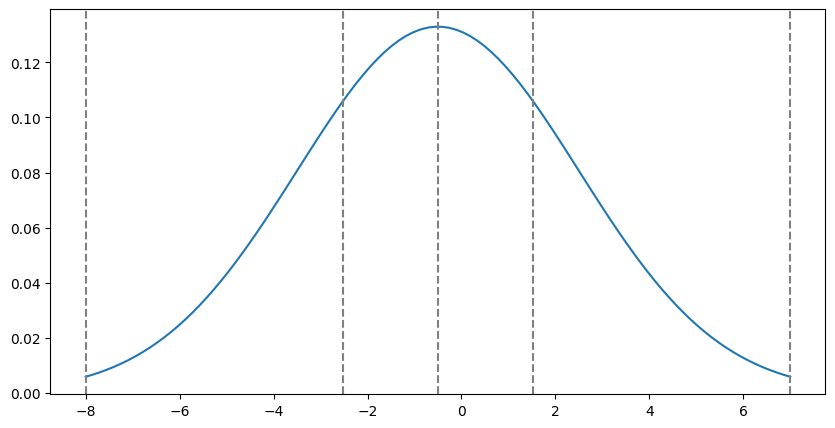

In [31]:
domain = np.linspace(*PreciseNum.range, 100)
plt.figure(figsize=(10, 5))
plt.plot(domain, precise_distribution.pdf(domain))
for boundary in reg_boundaries_precise: plt.axvline(x=boundary, color='gray', linestyle='--')
plt.show()

**Important:** These are values in the precise range. But we want to divide up the target range.

Let's write functions to map ranges into each other.

In [32]:
def map_range(x, orig_range, dest_range): # maps x from orig_range into dest_range
    min_orig,max_orig = orig_range
    min_dest,max_dest = dest_range
    normalized_x = (x - min_orig) / (max_orig - min_orig)  # scale from [min_orig, max_orig] to [0,1]    
    return normalized_x * (max_dest - min_dest) + min_dest # Scale from [0,1] to [min_dest, max_dest]    

precise_range = (PreciseNum.min_val, PreciseNum.max_val)
rough_range   = (RoughNum.min_val,   RoughNum.max_val)

def precise2tgt_range(x): return map_range(x, orig_range=precise_range, dest_range=tgt_rng)
def rough2tgt_range(x):   return map_range(x, orig_range=rough_range,   dest_range=tgt_rng)

def tgt2precice_range(x): return map_range(x, orig_range=tgt_rng, dest_range=precise_range)
def tgt2rough_range(x):   return map_range(x, orig_range=tgt_rng, dest_range=rough_range)

# assertions
for t,p in zip(tgt_rng, precise_range): assert tgt2precice_range(t)==p # end points of ranges should map to each other
for t,r in zip(tgt_rng, rough_range)  : assert tgt2rough_range(t)  ==r # end points of ranges should map to each other

assert precise2tgt_range(tgt2precice_range(-100)) == -100 # mapping from precise -> target -> precise should not change anything
assert rough2tgt_range(  tgt2rough_range(  -100)) == -100 # mapping from rough   -> target -> rough   should not change anything

Cool, now we can use `precise2tgt_range` to map our regions in the precise range to regions in the target range.

In [33]:
reg_boundaries = [precise2tgt_range(b) for b in reg_boundaries_precise]
reprs = [pick_repr(r) for r in pairwise(reg_boundaries)]

for i, ((a_tgt,b_tgt), r) in enumerate(zip(pairwise(reg_boundaries), reprs)):
    print(f'In the target range, region {i} is ({a_tgt:>7.2f}, {b_tgt:>7.2f}) (represented by {r:>5.1f}).')

In the target range, region 0 is (-100.00,    9.53) (represented by -45.2).
In the target range, region 1 is (   9.53,   50.00) (represented by  29.8).
In the target range, region 2 is (  50.00,   90.47) (represented by  70.2).
In the target range, region 3 is (  90.47,  200.00) (represented by 145.2).


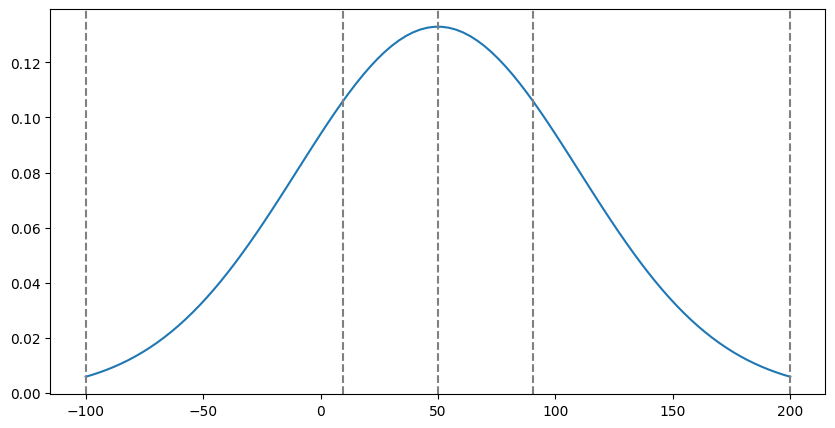

In [34]:
target_pdf = lambda x: precise_distribution.pdf(tgt2precice_range(x))

domain = np.linspace(*tgt_rng, 100)
plt.figure(figsize=(10, 5))
plt.plot(domain, target_pdf(domain))
for boundary in reg_boundaries: plt.axvline(x=boundary, color='gray', linestyle='--')
plt.show()

Let's define `to_repr` again, so it used the updated `reg_boundaries`.

In [35]:
# same code as above
def to_repr(x):
    # map a value in target range to its representative 
    for b,r in zip(reg_boundaries[1:], reprs):
        if x <= b: return r
    raise RuntimeError(f'Can\'t map {x} to a representative')

Let's experimentally check that about the same number of input elements end up in each region.

In [36]:
n_samples = 1000
x = normal_precise_nums(std=3, n_samples=n_samples)

repr2freq = Counter([to_repr(precise2tgt_range(x_.val)) for x_ in x]) # how often does an input end up in a region (defined by its representative)?
repr2freq = {r:f for r,f in repr2freq.items() }
assert sum(repr2freq.values()) == n_samples

print(f'Out of {n_samples} input data points...')
for i,r in enumerate(sorted(repr2freq.keys())): print(f'\t{repr2freq [r]:>3} are mapped into region ({reg_boundaries[i]:>7.2f}, {reg_boundaries[i+1]:>7.2f}) (represented by {r:>5.1f})')

Out of 1000 input data points...
	288 are mapped into region (-100.00,    9.53) (represented by -45.2)
	243 are mapped into region (   9.53,   50.00) (represented by  29.8)
	236 are mapped into region (  50.00,   90.47) (represented by  70.2)
	233 are mapped into region (  90.47,  200.00) (represented by 145.2)


These points are now way more evenly distributed!

In [37]:
repr2rough = {repr: rough for repr, rough in zip(reprs, RoughNum.range_iter())}
rough2repr = {rough: repr for repr, rough in repr2rough.items()}

# todo umer: update comment
def precise2rough(x):
    assert isinstance(x, PreciseNum)
    x = x.val
    x = precise2tgt_range(x) # eg PreciseNum(-7) -> (-100,-25)
    x = to_repr(x)           # eg (-100,-25)      -> -62.5
    x = repr2rough[x]        # eg -62.5           -> RoughNum(0)
    return RoughNum(x)

assert precise2rough(PreciseNum(-7)) == RoughNum(0)

In [38]:
print('Mapping of PreciseNum -> RoughNum ')
for x in PreciseNum.range_iter(): print(f'{x:>2} -> {precise2rough(PreciseNum(x)).val}')

Mapping of PreciseNum -> RoughNum 
-8 -> 0
-7 -> 0
-6 -> 0
-5 -> 0
-4 -> 0
-3 -> 0
-2 -> 1
-1 -> 1
 0 -> 2
 1 -> 2
 2 -> 3
 3 -> 3
 4 -> 3
 5 -> 3
 6 -> 3
 7 -> 3


Note how the rough values 1 and 2 each now encode only 2 precise values, but the rough values 0 and 3 each now encode 6 precise values.

In [39]:
print('PreciseNum --quanting--> RoughNum --dequanting--> PreciseNum')
for x in PreciseNum.range_iter():
    x = PreciseNum(x)
    x_rough = precise2rough(x)
    x_reconstructed = rough2precise(x_rough)
    print(f'{x.val:>2} -> {x_rough.val} -> {x_reconstructed.val:>2}')

PreciseNum --quanting--> RoughNum --dequanting--> PreciseNum
-8 -> 0 -> -8
-7 -> 0 -> -8
-6 -> 0 -> -8
-5 -> 0 -> -8
-4 -> 0 -> -8
-3 -> 0 -> -8
-2 -> 1 -> -3
-1 -> 1 -> -3
 0 -> 2 ->  2
 1 -> 2 ->  2
 2 -> 3 ->  7
 3 -> 3 ->  7
 4 -> 3 ->  7
 5 -> 3 ->  7
 6 -> 3 ->  7
 7 -> 3 ->  7


## Asymmetric Quantile Quanting

You might have noticed that quanting and then dequanting 0 changes it to a non-zero values.

In [40]:
x = PreciseNum(0)
x_rough = precise2rough(x)
x_reconstructed = rough2precise(x_rough)

print(f'A precise {x.val:>2} is quanted into a rough {x_rough.val}, and dequanted into a precise {x_reconstructed.val:>2}.')

A precise  0 is quanted into a rough 2, and dequanted into a precise  2.


This is bad, because **Todo Umer:** why exactly?

To fix this, we do something called 'asymmetric quanting'. This can be be applied to naive quanting as well, but we'll directly apply it to quantile quanting.

With 2 bits, we have 4 rough values. So far, we have divided up the target region (with total p'mass of 1) into 4 areas of equal p'mass. The main idea now is to reserve a region around 0 and pick 0 as its representative, and then independently divide the negative numbers into 4/2-1 = 1 regions of equal p'mass and the positive numbers into 4/2 = 2 regions of equal p'mass. This totals 1 + 1 + 2 = 4 regions.

In [41]:
bits = RoughNum.n_bits

n_reg_pos = int((bits**2)/2)
n_reg_neg = int(((bits**2)/2)-1)

print(f'For {bits} bits, asymmetric quanting gives us {n_reg_neg} region(s) for negative numbers, 1 region around zero, and {n_reg_pos} regions for positive numbers.')

For 2 bits, asymmetric quanting gives us 1 region(s) for negative numbers, 1 region around zero, and 2 regions for positive numbers.


In [42]:
pmass_per_neg_region = 0.5 / n_reg_neg
pmass_per_pos_region = 0.5 / n_reg_pos

print(f'Each negative region has p\'mass {pmass_per_neg_region:.2f}')
print(f'Each positive region has p\'mass {pmass_per_pos_region:.2f}')

Each negative region has p'mass 0.50
Each positive region has p'mass 0.25


In [ ]:
def clamp_prec(x,a=PreciseNum.min_val,b=PreciseNum.max_val):
    if x < a: return a
    if x > b: return b
    return x
        
reg_boundaries_precise = [
    clamp_prec(ppf(i*pmass_per_region)) for i in range(RoughNum.n_bits**2 + 1)
]

for a_prec,b_prec in pairwise(reg_boundaries_precise):
    pmass = cdf(b_prec)-cdf(a_prec)
    print(f'\tIn the precise range, region ({a_prec:>5.2f}, {b_prec:>5.2f}) has pmass {pmass:.4f}.')

In [ ]:
q_ctrs = tensor([
    *[norm.ppf(0.5 - area_region_neg*i) for i in range(1,n_ctr_neg+1)],
    0,
    *[norm.ppf(0.5 + area_region_pos*i) for i in range(1,n_ctr_pos+1)]
])
q_ctrs

In [ ]:
print(f'These are the {bits**2} numbers that our quanting scheme will map every input onto.')

In [ ]:
domain = torch.linspace(-4, 4, 100)
plt.figure(figsize=(10, 5))
plt.plot(domain, norm.pdf(domain))
#for c in q_ctrs: plt.axvline(x=c, color='gray', linestyle='--')
plt.scatter(q_ctrs, [0]*len(q_ctrs), color='red', s=30)
plt.show()

Let's check that the probability mass between is as expected

In [ ]:
for c1,c2 in pairwise(q_ctrs[0:n_ctr_neg].tolist() + [0]):
    # in negative region, p'mass between any 2 centers equals p'mass of (-inf, left most center)
    assert np.isclose(norm.cdf(c2) - norm.cdf(c1),  norm.cdf(q_ctrs[0]))

for c1,c2 in pairwise([0] + q_ctrs[n_ctr_pos:].tolist()):
    # in positive region, p'mass between any 2 centers equals p'mass of (right most center, inf)
    assert np.isclose(norm.cdf(c2) - norm.cdf(c1), 1-norm.cdf(q_ctrs[-1]))